## Imports, Paths, View Examples

In [28]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imutils
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.feature_extraction import image
from tqdm import tqdm

# Define paths
#base_dir = '/content/drive/MyDrive/logo_detection/logo_detection_w281/' # Colab/GDrive
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
os.chdir(base_dir)

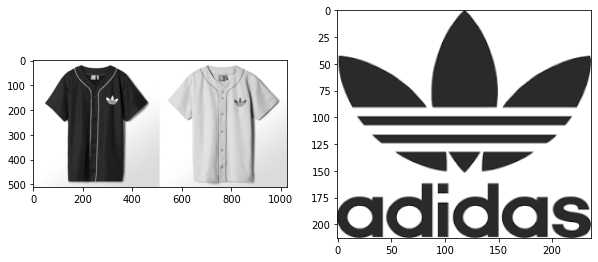

In [9]:
# Load example image and reference
adidas_dir = image_dir + 'adidas/'
img_file = adidas_dir + os.listdir(adidas_dir)[0]
img_rgb = cv2.imread(img_file)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Load adidas template
ref_dir = base_dir + 'data/logo_references/adidas/'
ref_file = ref_dir + os.listdir(ref_dir)[0] 
ref_rgb = cv2.imread(ref_file)
ref_gray = cv2.cvtColor(ref_rgb, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_gray, cmap='gray')
ax[1].imshow(ref_gray, cmap='gray')
plt.show()

## Helper Functions
1. resize_reference(ref, scale_percent)
    - Resize the reference image in case it is smaller or large in the input image (unlikely to be perfect match to start)
2. find_matches:
    - Find 1 or multiple matches of logo reference in the input image
    - The number of bounding boxes is determined by the number of points that beat a threshold criteria
        - If none meet criteria, we pick the box with the greatest likelihood value
    - Given reference image, take the inverted version and perform template matching here as well
        - If neither normal or inverted reference find a box that beats threshold, pick the best of the 2 instead of picking one of each
    - TO-DO:
        - If multiple boxes overlap, pick the best of the set
        - Determine optimal threshold
            - One approach: Get the # of boxes returned at each threshold increment, find the threshold that has steepest drop off (ex: dropoff from 50 boxes to 3)
            - Another idea: Given the max likelihood bounding box, only return other bounding boxes within a certain range of the max (ex: can't return bbox with 40% likelihood if another has 75%, even if 40% is the next most likely)


In [10]:
# Try other shapes for reference
def resize_reference(ref, scale_percent):
    ref_copy = ref.copy()
    width = int(ref_copy.shape[1] * scale_percent)
    height = int(ref_copy.shape[0] * scale_percent)
    ref_re = cv2.resize(ref_copy, (width, height))
    return ref_re

In [11]:
# If many boxes are above threshold, pick to n=max_boxes while ensuring that none overlap
def select_top_boxes(bbox_pts, bbox_stats, w, h, overlap_buffer = 0.9, max_boxes = 3):
    # sort pts by score/stat descending
    z = list(zip(bbox_pts, bbox_stats))
    z = sorted(z, key = lambda x: -x[1])

    # keep running list of bboxes, stats to retain
    final_pts = np.array([z[0][0]]) 
    final_stats = [z[0][1]]

    # loop through each bbox above threshold, sorted by stat, avoid overlaps, only take top n=max_boxes
    for i in range(len(z[1:])):
        pt = z[i][0]
        stat = z[i][1]

        # check if max boxes reached
        if len(final_pts) < max_boxes:
            # check for overlap w/ top pts
            pt_x = pt[0]
            pt_y = pt[1]
            fin_pts_x = final_pts[:, 0]
            fin_pts_y = final_pts[:, 1] 
            x_olap = np.abs(fin_pts_x - pt_x) < (w*overlap_buffer)
            y_olap = np.abs(fin_pts_y - pt_y) < (h*overlap_buffer)
            olap = np.array(list(zip(x_olap, y_olap)))

            if np.any((olap[:, 0] == True) & (olap[:, 1] == True)): # there is overlap of boxes
                pass
            else: # no overlap, add to final set
                final_pts = np.vstack([final_pts, pt])
                final_stats.append(stat)

        else: # max boxes reached
            break

    return final_pts, final_stats

In [12]:
def find_matches(img_rgb, img_gray, ref, 
                 method='cv2.TM_CCOEFF_NORMED',
                 threshold = 0.4, 
                 overlap_buffer=0.9,
                 max_boxes = 3):

    # init
    img_copy = img_gray.copy()
    img_rgb_copy = img_rgb.copy()
    ref_copy = ref.copy()
    w, h = ref_copy.shape[::-1]
    method = eval(method)
    bbox_pts = [] # array of all points above threshold
    bbox_stats = [] # array of likelihood values for each box returned

    # Perform template matching - normal reference
    res = cv2.matchTemplate(img_copy, ref_copy, method)
    loc = np.where(np.abs(res) >= threshold) # find all box locations that beat threshold
    pts = [x for x in zip(*loc[::-1])]

    # Perform template matching - inverted reference
    res_inv = cv2.matchTemplate(img_copy, 255-ref_copy, method)
    loc_inv = np.where(np.abs(res_inv) >= threshold)
    pts_inv = [x for x in zip(*loc_inv[::-1])]

    # get unique bbox pts
    for pt in pts:
        bbox_pts.append(pt)
        bbox_stats.append(np.abs(res[pt[1], pt[0]]))
    for pt in pts_inv:
        if pt not in bbox_pts: 
            bbox_pts.append(pt)
            bbox_stats.append(np.abs(res_inv[pt[1], pt[0]]))

    if len(bbox_pts) > 0: # if any above threshold
        # Take only top n=max_boxes points
        final_pts, final_stats = select_top_boxes(bbox_pts, bbox_stats, w, h, overlap_buffer, max_boxes)

        # create recentangles for bboxes above threshold
        for point in final_pts:
            cv2.rectangle(img_rgb_copy, point, (point[0] + w, point[1] + h), (0,0,255), 2)

        return img_rgb_copy, final_pts, final_stats, len(bbox_pts)

    # If neither reference returns a box that beats threshold, get best box from both references and pick best of the two
    else:
        # next best box for normal, inverted references
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        min_val_inv, max_val_inv, min_loc_inv, max_loc_inv = cv2.minMaxLoc(res_inv)
        # go with best of the two above
        if max_val > max_val_inv: # use best box from normal reference
            top_left = max_loc
            bbox_stats.append(max_val)
            bottom_right = (top_left[0] + w, top_left[1] + h)
            rect = cv2.rectangle(img_rgb_copy, top_left, bottom_right, (0,0,255), 2)
        else: # inverted reference returned the most likely bounding box
            top_left = max_loc_inv
            bbox_stats.append(max_val_inv)
            bottom_right = (top_left[0] + w, top_left[1] + h)
            rect = cv2.rectangle(img_rgb_copy, top_left, bottom_right, (0,0,255), 2)

        return img_rgb_copy, bbox_pts, bbox_stats, len(bbox_pts)

[(array([811, 152]), 0.4390722), (array([296, 147]), 0.4041095), (array([781, 460]), 0.3833504)]
Initially 124 are above threshold, top 3 with no overlap selected 


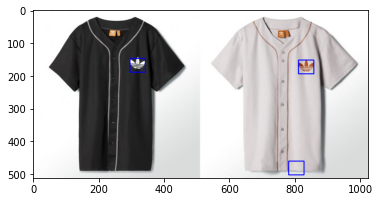

In [13]:
## Ideal case
# Without inverted reference above and we would not get the black jersey box
ref_resize = resize_reference(ref_gray, 0.2) # resize
result, bbox_pts, bbox_stats, init_bboxes = find_matches(img_rgb, img_gray, ref_resize,
                                                        threshold=0.3, overlap_buffer=0.8, max_boxes=3)
print(list(zip(bbox_pts, bbox_stats)))
print(f"Initially {init_bboxes} are above threshold, top {len(bbox_pts)} with no overlap selected ")
plt.imshow(result)

### Areas to Explore
1. Find optimal image size
2. Find optimal threshold (diff threshold for each logo?)
3. Other transformations to reference image (to do)
4. Different template match methods

In [21]:
# DF to track experiment results
def create_df():
    df = pd.DataFrame({
        'input_img': np.array([]),
        'ref_resize': np.array([], dtype='float32'), 
        'ref_rotation': np.array([], dtype=int),
        'method': np.array([]),
        'threshold': np.array([], dtype='float32'),
        'num_bboxes_fin': np.array([], dtype=int),
        'bbox_values': np.array([], dtype='float32'),
        'bbox_avg': np.array([], dtype='float32'),
        'max_boxes': np.array([], dtype=int),
        'num_init_bboxes_threshold': np.array([], dtype=int),
        }
    )

    return df

### Experiment 1: Resize Reference Image

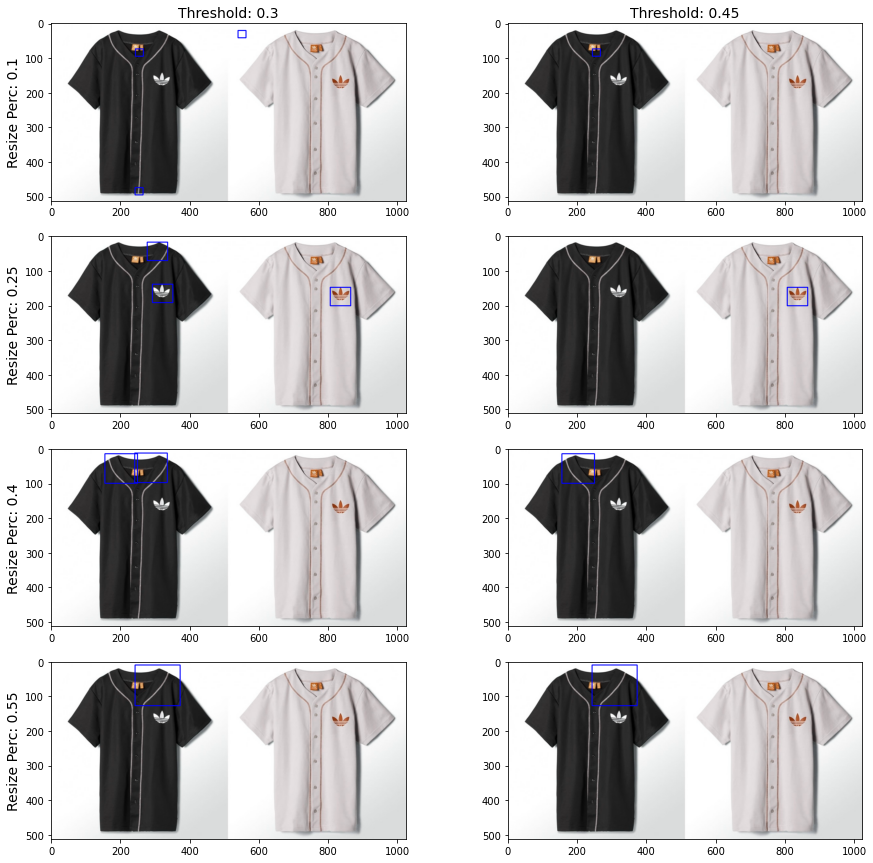

In [22]:
percs = np.arange(0.1, 0.6, 0.15)
thresholds = np.arange(0.3, 0.6, 0.15)
max_boxes=3
df = create_df()

fig, ax = plt.subplots(len(percs), len(thresholds), figsize=(15, 15))

# run loop
for j in range(len(thresholds)):
    threshold = thresholds[j]
    ax[0, j].set_title(f"Threshold: {round(threshold, 2)}", size=14)
    for i in range(len(percs)):
        ax[i, 0].set_ylabel(f"Resize Perc: {round(percs[i], 2)}", rotation=90, size=14)
        ref_resize = resize_reference(ref_gray, percs[i]) # resize
        result, bbox_pts, bbox_stats, init_bboxes = find_matches(img_rgb, img_gray, ref_resize,
                                                                threshold=threshold, overlap_buffer=0.8, max_boxes=max_boxes)
        df.loc[len(df.index)] = [img_file, percs[i], 0, 'cv2.TM_CCOEFF_NORMED',
                                threshold, len(bbox_stats), bbox_stats,
                                np.mean(bbox_stats), max_boxes, init_bboxes]
        ax[i, j].imshow(result)

### Experiment 2: Rotate Reference

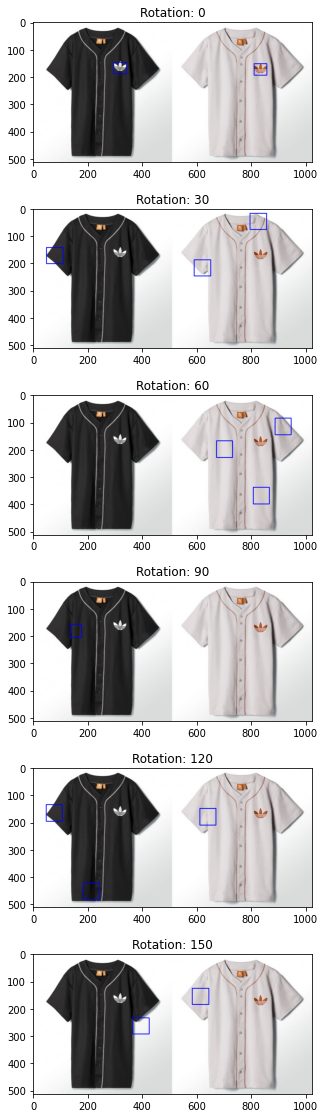

In [23]:
angles = np.arange(0, 180, 30)
perc = 0.2
threshold = 0.4
overlap_buffer = 0.8
max_boxes = 3
method='cv2.TM_CCOEFF_NORMED'

fig, ax = plt.subplots(len(angles), 1, figsize=(5, 20))

# run loop
for i in range(len(angles)):
    ax[i].set_title(f"Rotation: {angles[i]}")
    ref_resize = resize_reference(ref_gray, perc) # resize
    ref_rotate = imutils.rotate_bound(ref_resize, angles[i]) #rotate_bound handles corners properly without cutoff
    result, bbox_pts, bbox_stats, init_bboxes = find_matches(img_rgb, img_gray, ref_rotate, method,
                                                            threshold, overlap_buffer, max_boxes)
    df.loc[len(df.index)] = [img_file, perc, angles[i], method,
                            threshold, len(bbox_stats), bbox_stats, 
                            np.mean(bbox_stats), max_boxes, init_bboxes]
    ax[i].imshow(result)

### QUESTION: How do we define the best match?
Potential Solution 1: Average the scores of each bounding box, take max


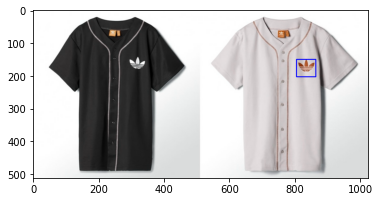

In [24]:
def eval_combos(df, img_rgb, img_gray, ref_gray, overlap_buffer=0.8):
    top_combo = np.argmax(df['bbox_avg'])
    resize_perc = df.loc[top_combo, 'ref_resize']
    angle = df.loc[top_combo, 'ref_rotation']
    threshold = df.loc[top_combo, 'threshold']
    method = df.loc[top_combo, 'method']
    max_boxes = df.loc[top_combo, 'max_boxes']

    ref_resize = resize_reference(ref_gray, resize_perc) # resize
    ref_rotate = imutils.rotate_bound(ref_resize, angle) #rotate_bound handles corners properly without cutoff
    
    # -------- PROB SHOULD JUST PULL OUT THE COORDINATES AND ADD RECTANGLE TO RGB IMGS
    result, bbox_pts, bbox_stats, init_bboxes = find_matches(img_rgb, img_gray, ref_rotate, method,
                                                            threshold, overlap_buffer, max_boxes)
    plt.imshow(result)

eval_combos(df, img_rgb, img_gray, ref_gray)

### Greedy Box Search: Try all sizes, rotations

100%|██████████| 4/4 [01:02<00:00, 15.71s/it]


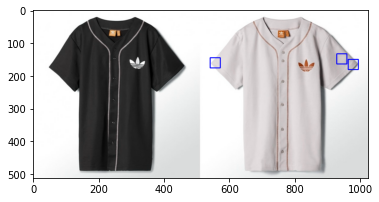

In [33]:
resize_percs = np.arange(0.1, 0.6, 0.15)
#thresholds = np.arange(0.3, 0.601, 0.15)
threshold = 0.35
angles = np.arange(0, 360, 15)
overlap_buffer = 0.8
max_boxes = 3
method='cv2.TM_CCOEFF_NORMED'

df1 = create_df()

for resize in tqdm(resize_percs):
    for angle in angles:
        #for threshold in thresholds:
        ref_resize = resize_reference(ref_gray, resize) # resize
        ref_rotate = imutils.rotate_bound(ref_resize, angle) #rotate_bound handles corners properly without cutoff
        result, bbox_pts, bbox_stats, init_bboxes = find_matches(img_rgb, img_gray, ref_rotate, method,
                                                                threshold, overlap_buffer, max_boxes)
        df1.loc[len(df1.index)] = [img_file, resize, angle, method,
                                  threshold, len(bbox_stats), bbox_stats,
                                  np.mean(bbox_stats), max_boxes, init_bboxes]


eval_combos(df1, img_rgb, img_gray, ref_gray)

### Experiment 3: Harris Corners

In [ ]:
# input a grayscale image and draw keypoints
def drawKeyPts(grayImage, keyp):
    
    out_im = (grayImage * 255).astype(np.uint8)
    out_im = np.concatenate((out_im[:,:,np.newaxis], 
                             out_im[:,:,np.newaxis], 
                             out_im[:,:,np.newaxis]), axis=2)
    
    for curKey in keyp:
        x=np.int32(curKey.pt[0])
        y=np.int32(curKey.pt[1])
        size = np.int32(curKey.size)
        cv2.circle(out_im, (x,y), 8, [255, 0, 0], 
                   thickness=1, lineType=8, shift=0)

    return out_im
    

# compute the key points from input grayscale images
def HarrisKeypointDetector(in_image, n=2, w=3, k=0.04, verbose=True):
    
    # STEP 1:
    # compute the points where there are good corners in the image
    # the score for good corners are computed as follows:
    # harrisImage = det(H) - k(trace(H))^2
    # where H = A.T*A seen in the async lecture
    
    # parameters to cv2.cornerHarris are:
    #   grayscale image
    #   n = size of the window to compute the A
    #   w = size of the kernel to compute the gradients
    #   k = value for k in det(H) - k(trace(H))^2
    harrisImage = cv2.cornerHarris(in_image, n, w, k)
    
    # STEP 2:
    # threshold the scores to keep only interesting features
    thresh = 0.1 * harrisImage.max()
    harrisMaxImage = harrisImage > thresh
    
    # STEP 3:
    # get keypoints structure from the detected features
    height, width = in_image.shape[:2]
    features = []
    for y in range(height):
        for x in range(width):
            
            # do not include if it is not in the good features
            if not harrisMaxImage[y, x]:
                continue

            # fill in the parameters
            f = cv2.KeyPoint()
            f.pt = (x, y)
            f.response = harrisImage[y,x]
            features.append(f)

    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
        ax[0].imshow(drawKeyPts(in_image, features)); ax[0].axis('off')
        ax[0].set_title('image')
        har_im = ax[1].imshow(harrisImage, cmap='gray'); ax[1].axis('off')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(har_im, cax=cax)
        ax[1].set_title('score')
        plt.suptitle('KEYPOINTS')
        plt.show()
            
    return features

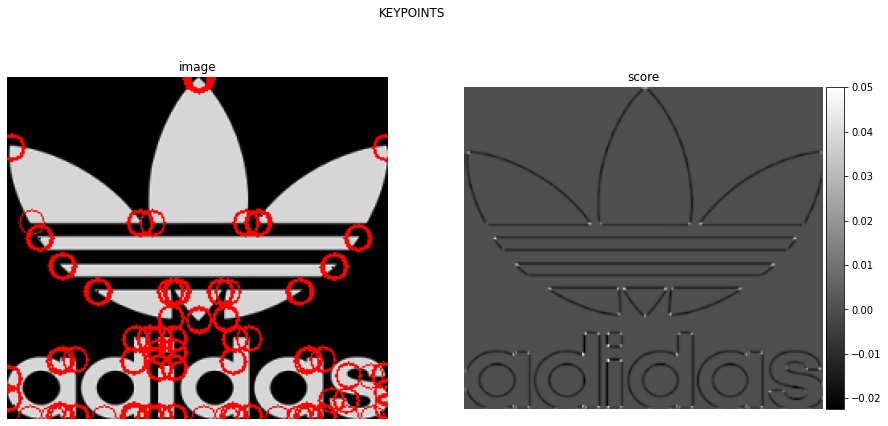

In [ ]:
features = HarrisKeypointDetector(ref_gray, n=2, w=3, k=0.04, verbose=True)

In [ ]:
# get simple feature detector with only pixel values around wxw window
def SimpleFeatureDescriptor(grayImage, keypoints, w=5):
    
    # for every keypoint get the pixel values around 5x5 window
    grayImage1 = np.pad(grayImage, [(w,w), (w,w)], mode='constant')
    desc = np.zeros((len(keypoints), w*w), np.float32)

    for i, f in enumerate(keypoints):
        x, y = f.pt
        x, y = np.int32(x), np.int32(y)
        x=x+w
        y=y+w

        each_desc = grayImage1[y - w//2 : y + w//2 + 1, 
                               x - w//2 : x + w//2 + 1].reshape([1, w*w])
        desc[i, :] = each_desc

    return desc

# more robust feature descriptor using ORB
def ORBFeatureDescriptor(grayImage, keypoints):
    orb = cv2.ORB_create() # cv2.SIFT_create() #
    kp, des = orb.compute((grayImage * 255).astype(np.uint8), keypoints)
    return des


# match the input feature descriptors using a simple brute force search
def feature_matching(desc1, desc2):
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    return good

In [ ]:

# read grayscale image with intensity range between 0-1
def read_image(in_path):

    img = plt.imread(in_path)
    
    # floating point image with intensity [0, 1]
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0
    
    # convert to grayscale
    if len(img.shape) > 2:
        img = img[:, :, 2].copy()
        
    return img


# feature tracking pipeline
def feature_tracking(im1_path, im2_path, n=2, w=5):
    
    # IMAGES
    im1 = read_image(im1_path)
    im2 = read_image(im2_path)
    
    # detect the features
    kp1 = HarrisKeypointDetector(im1, n=2)
    kp2 = HarrisKeypointDetector(im2, n=2)
        
    # describe features
    desc1 = SimpleFeatureDescriptor(im1, kp1, w)
    desc2 = SimpleFeatureDescriptor(im2, kp2, w)
        
    # match good features
    good_matches = feature_matching(desc1, desc2)
    
    # display the matches
    draw_params = dict(matchColor = (255, 0, 0), # draw matches in green
                       singlePointColor = None, # draw only inliers
                       flags = 2)

    match_img = cv2.drawMatches((im1*255).astype(np.uint8), kp1, 
                                (im2*255).astype(np.uint8), kp2, 
                                good_matches, None, **draw_params)
    
    fig = plt.figure(figsize=(15,7))
    plt.imshow(match_img)
    plt.axis('off')
    plt.title('MATCHES')
    plt.show()


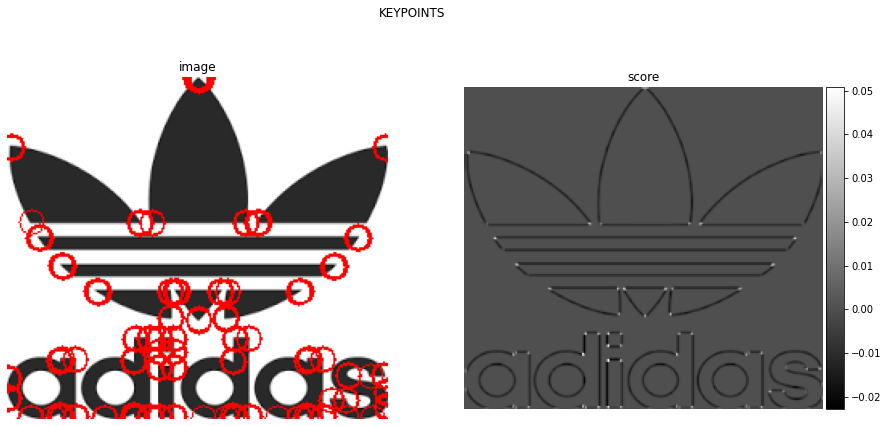

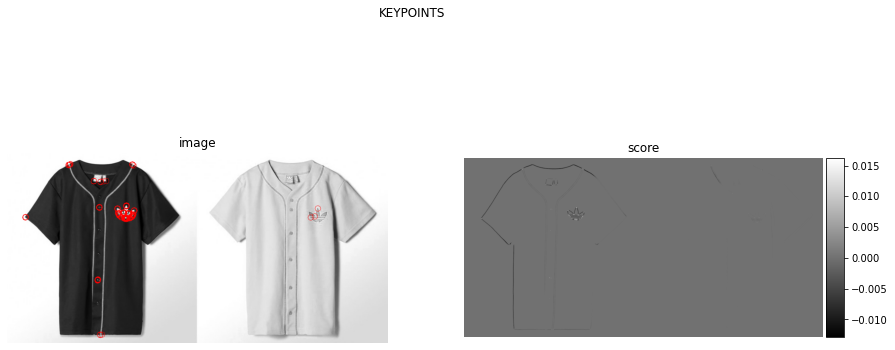

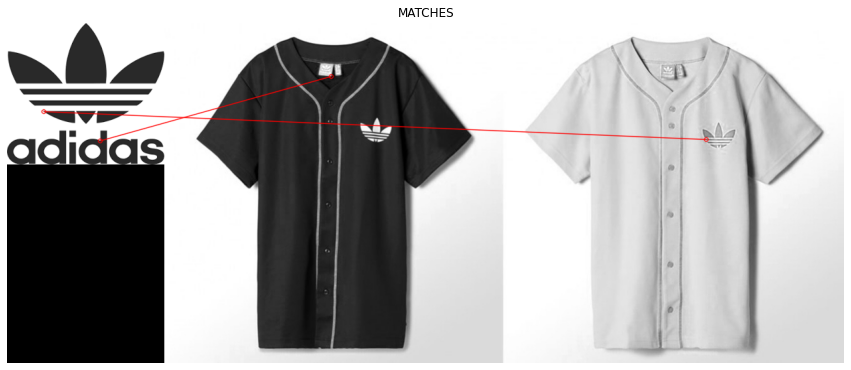

In [ ]:
feature_tracking(ref_file, img_file, n=15, w=7)

### Experiment X: Try diff Template Match Methods
Challenge: difficult to compare across metrics which is best without labeled bbox data set

In [ ]:
# methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
# 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
# vals = np.array([])

# fig, ax = plt.subplots(len(methods), 1, figsize=(5, 15))
# for i in range(len(methods)):
#     ref_resize = resize_reference(r_copy, 0.2) # resize
#     rect_res, val = find_matches(rgb, gray, ref_resize, methods[i]) # eval
#     vals = np.append(vals, val)
#     df.loc[len(df.index)] = [val, ref_resize.shape, methods[i]]
#     ax[i].imshow(rect_res)

# print(list(zip(methods, vals)))